In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import IPython.display as ipd

from local_signal import *
from general import *


(512, 512)


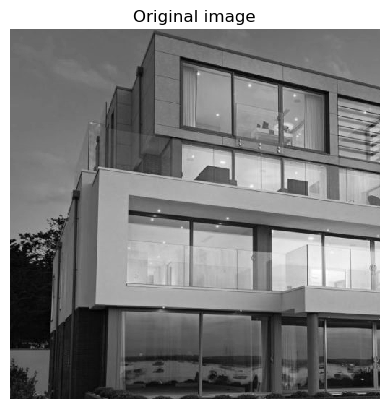

In [60]:
image = load_image('apartment.jpg')
#resize to 512x512
image = image[100:612, 100:612]
image_shape = image.shape
print(image.shape)

imageplot(image, "Original image")

In [61]:
def get_variance(snr, image, noise):
    """
    Function that computes the required variance of the noise to achieve a given SNR.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noise)**2
    #compute the variance
    # variance = norm/(noise_norm*(np.exp((snr/10))))
    variance = norm/(noise_norm*(10**(snr/10)))
    return variance

def generate_noisy_image(snr, image):
    """ 
    Function that generates a noisy image with a given SNR.
    """
    noise = np.random.normal(0, 1, image.shape)
    variance = get_variance(snr, image, noise)
    sigma = np.sqrt(variance)
    noisy_image = image + noise * sigma
    return sigma, noisy_image

def compute_snr(image, noisy_image):
    """
    Function that computes the SNR between an image and a noisy image.
    """
    #get the norm of the image and the noise
    norm = np.linalg.norm(image)**2
    noise_norm = np.linalg.norm(noisy_image - image)**2
    #compute the SNR
    snr = 10*np.log10(norm/noise_norm)
    return snr

0.11035444543676778


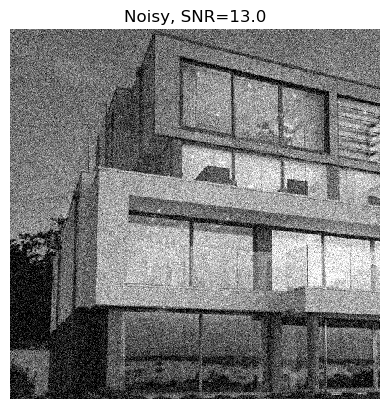

In [150]:
target_SNR = 13
noise_sigma, noisy_image = generate_noisy_image(target_SNR, image)
print(noise_sigma)
imageplot(clamp(noisy_image), "Noisy, SNR=" + str(compute_snr(image, noisy_image)))

The wavelet transform uses 2 paremeters: an orthogonal wavelet, and the number of levels/coefficients to compute.

In the wavelet domain, it is possible to apply a thresholding function (hard or soft) to the coefficients, and then to reconstruct the image using the inverse wavelet transform.

The wavelet used is the Daubechies-4 wavelet.

The number of coefficients to compute is based on Jmin; for an image of size $2^n$, the number of coefficients computed is $2^{n-Jmin}$.

The more coefficients are computed, the better the quality of the image recovered is; however, for a perfect recovery we would need an infinite number of levels (coefficients).

Hard thresholding sets the value of the coefficients below a certain threshold to 0.

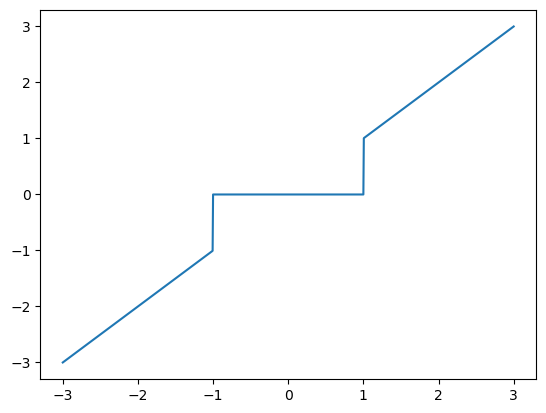

In [151]:
def thresh_hard(u,t):return u*(abs(u)>t)
alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_hard(alpha,1))
plt.show()

In [152]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/np.linalg.norm(h)

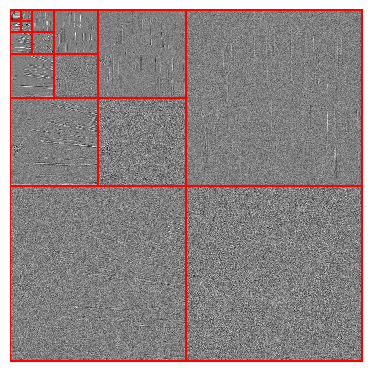

In [167]:
Jmin = 4
a = perform_wavortho_transf(noisy_image,Jmin,+1,h)
plot_wavelet(a,Jmin);

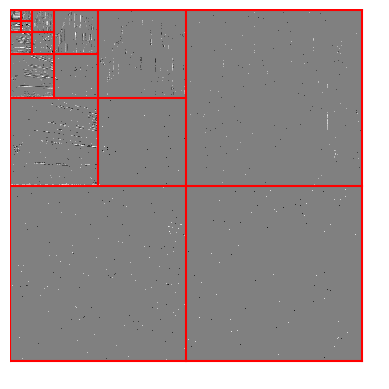

In [168]:
T = 3*noise_sigma
aT = thresh_hard(a,T)
plot_wavelet(aT,Jmin);


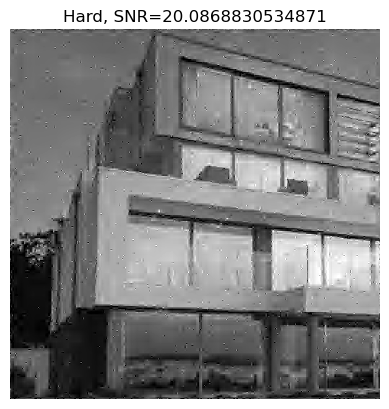

In [169]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fHard), 'Hard, SNR=' + str(snr(image,fHard)) )

Soft thresholding decreases the value of the coefficients below a certain threshold by the threshold value; in other words, it is setting the value of the coefficients below a certain threshold to 0, and then adding the threshold value to the remaining coefficients.

(-3.3, 3.3, -2.2, 2.2)

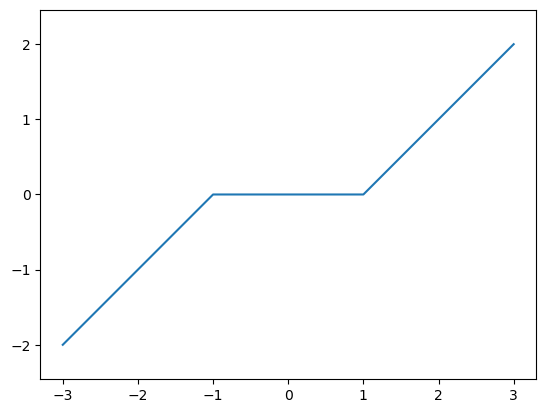

In [170]:
def thresh_soft(u,t):return np.maximum(1-t/abs(u), 0)*u
alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_soft(alpha,1))
plt.axis('equal')

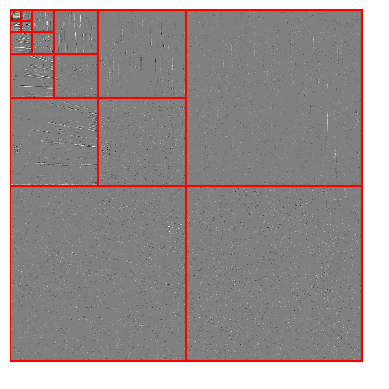

In [171]:
T = 3/2*noise_sigma
aT = thresh_soft(a,T)
plot_wavelet(aT,Jmin);


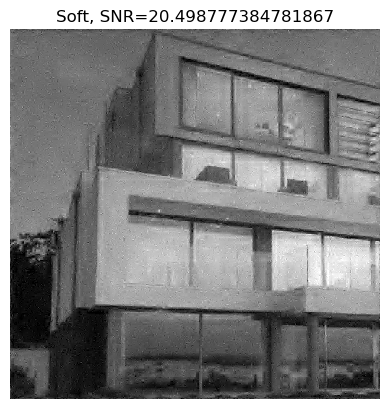

In [172]:
#To slightly improve the soft thresholding performance, we do not threshold the coefficients corresponding to coarse scale wavelets.
aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]

fSoft = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fSoft), 'Soft, SNR=' + str(snr(image,fSoft)) )


The soft thresholding function is less sensitive to noise than the hard thresholding function, but it is also less efficient at removing noise. As a result, it maintains more details than the hard thresholding function at the cost of also preserving some noise.

Translation invariant denoising

In [173]:
m = 4
[dY,dX] = np.meshgrid(np.arange(0,m), np.arange(0,m))
delta = np.concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)


In [174]:
fTI = np.zeros(image_shape)
T = 3*noise_sigma
for i in np.arange(0,m*m):
    fS = circshift(noisy_image,delta[i,:])
    a = perform_wavortho_transf(fS,Jmin,1,h)
    aT = thresh_hard(a,T)
    fS = perform_wavortho_transf(aT,Jmin,-1,h)
    fS = circshift(fS,-delta[i,:])
    fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS

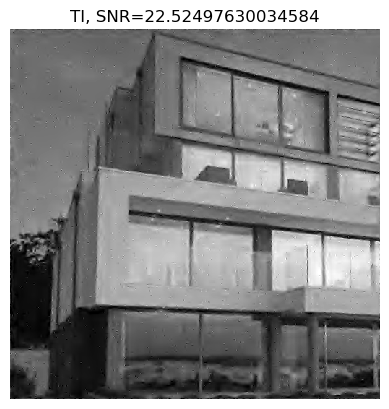

In [175]:
imageplot(clamp(fTI), 'TI, SNR=' + str(snr(image,fTI)) )
